In [10]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from datetime import timedelta

In [2]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

#### Red cell distribution widt (RDW)

In [42]:
# Load D_LABITEMS to verify the correct ITEMIDs
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/D_LABITEMS.csv.gz') as gz_file:
        d_labitems = pd.read_csv(gz_file, compression='gzip')

# Search for Anion Gap
print("\n" + "=" * 80)
print("SEARCHING FOR HEMOGLOBIN IN D_LABITEMS")
print("=" * 80)
anion_gap_items = d_labitems[d_labitems['LABEL'].str.contains('hemato', case=False, na=False)]
print(anion_gap_items[['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']])


SEARCHING FOR HEMOGLOBIN IN D_LABITEMS
     ITEMID                                LABEL                      FLUID  \
2     51348                      Hematocrit, CSF  Cerebrospinal Fluid (CSF)   
23    51369              Hematocrit, Joint Fluid                Joint Fluid   
76    51422              Hematocrit, Other Fluid           Other Body Fluid   
99    51445                  Hematocrit, Pleural                    Pleural   
137   50810               Hematocrit, Calculated                      Blood   
441   51115                  Hematocrit, Ascites                    Ascites   
547   51221                           Hematocrit                      Blood   
562   51236  Inpatient Hematology/Oncology Smear                      Blood   
679   51480                           Hematocrit                      Urine   

       CATEGORY  
2    Hematology  
23   Hematology  
76   Hematology  
99   Hematology  
137   Blood Gas  
441  Hematology  
547  Hematology  
562  Hematology  
679  He

In [38]:
d_labitems[d_labitems['ITEMID'] == 51277]

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
603,477,51277,RDW,Blood,Hematology,788-0


In [12]:
# ============================================================================
# STEP 1: LOAD ICU STAYS DATA
# ============================================================================
print("Loading ICUSTAYS data...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')

# Convert INTIME to datetime
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Calculate 48h window
icustays['INTIME_48H'] = icustays['INTIME'] + timedelta(hours=48)

print(f"Loaded {len(icustays)} ICU stays")

Loading ICUSTAYS data...
Loaded 61532 ICU stays


In [13]:
# ============================================================================
# STEP 2: LOAD RDW DATA FROM LABEVENTS
# ============================================================================
print("\nLoading LABEVENTS data for RDW...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/LABEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        # RDW Item IDs
        # 51277: RDW (standard RDW, typically RDW-CV in %)
        rdw_itemids = [51277]
        
        rdw_chunks = []
        for i, chunk in enumerate(chunk_iterator):
            print(f"Processing LABEVENTS chunk {i+1}...")
            filtered = chunk[chunk['ITEMID'].isin(rdw_itemids)]
            if not filtered.empty:
                rdw_chunks.append(filtered)
        
        labevents_rdw = pd.concat(rdw_chunks, ignore_index=True)

print(f"Loaded {len(labevents_rdw)} RDW measurements")

# Convert CHARTTIME to datetime
labevents_rdw['CHARTTIME'] = pd.to_datetime(labevents_rdw['CHARTTIME'])


Loading LABEVENTS data for RDW...
Processing LABEVENTS chunk 1...
Processing LABEVENTS chunk 2...
Processing LABEVENTS chunk 3...
Processing LABEVENTS chunk 4...
Processing LABEVENTS chunk 5...
Processing LABEVENTS chunk 6...
Processing LABEVENTS chunk 7...
Processing LABEVENTS chunk 8...
Processing LABEVENTS chunk 9...
Processing LABEVENTS chunk 10...
Processing LABEVENTS chunk 11...
Processing LABEVENTS chunk 12...
Processing LABEVENTS chunk 13...
Processing LABEVENTS chunk 14...
Processing LABEVENTS chunk 15...
Processing LABEVENTS chunk 16...
Processing LABEVENTS chunk 17...
Processing LABEVENTS chunk 18...
Processing LABEVENTS chunk 19...
Processing LABEVENTS chunk 20...
Processing LABEVENTS chunk 21...
Processing LABEVENTS chunk 22...
Processing LABEVENTS chunk 23...
Processing LABEVENTS chunk 24...
Processing LABEVENTS chunk 25...
Processing LABEVENTS chunk 26...
Processing LABEVENTS chunk 27...
Processing LABEVENTS chunk 28...
Loaded 746817 RDW measurements


In [14]:
# ============================================================================
# STEP 3: MERGE WITH ICU STAYS AND FILTER FOR FIRST 48 HOURS
# ============================================================================
print("\nMerging RDW data with ICU stays...")
rdw_icu = labevents_rdw.merge(
    icustays[['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'INTIME_48H']], 
    on=['SUBJECT_ID', 'HADM_ID'], 
    how='inner'
)

# Filter for measurements within first 48 hours of ICU admission
rdw_icu = rdw_icu[
    (rdw_icu['CHARTTIME'] >= rdw_icu['INTIME']) & 
    (rdw_icu['CHARTTIME'] <= rdw_icu['INTIME_48H'])
]

print(f"Found {len(rdw_icu)} RDW measurements within first 48h of ICU admission")


Merging RDW data with ICU stays...
Found 153171 RDW measurements within first 48h of ICU admission


In [40]:
# ============================================================================
# STEP 4: CREATE FEATURES FROM RDW MEASUREMENTS
# ============================================================================
print("\nCreating RDW features...")

# Separate RDW-CV and RDW-SD
rdw_cv = rdw_icu[rdw_icu['ITEMID'] == 51277].copy()

# Create aggregated features for RDW-CV (most commonly used)
rdw_features_cv = rdw_cv.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'min', 'max', 'std', 'first', 'last', 'count']
}).reset_index()

rdw_features_cv.columns = [
    'ICUSTAY_ID', 
    'RDW_mean', 'RDW_min', 'RDW_max', 'RDW_std', 
    'RDW_first', 'RDW_last', 'RDW_count'
]


rdw_features = rdw_features_cv

# Calculate change features (delta between first and last measurement)
rdw_features['RDW_delta'] = rdw_features['RDW_last'] - rdw_features['RDW_first']

print(f"Created features for {len(rdw_features)} ICU stays")


Creating RDW features...
Created features for 56426 ICU stays


In [41]:
rdw_features.head(7)

,ICUSTAY_ID,RDW_mean,RDW_min,RDW_max,RDW_std,RDW_first,RDW_last,RDW_count,RDW_delta
0,200001,17.600000,17.5,17.7,0.141421,17.7,17.5,2,-0.2
1,200003,14.300000,14.1,14.5,0.282843,14.1,14.5,2,0.4
2,200006,15.566667,15.3,15.7,0.230940,15.7,15.3,3,-0.4
3,200007,13.200000,13.1,13.3,0.141421,13.3,13.1,2,-0.2
4,200009,15.214286,14.3,15.6,0.445079,14.3,15.6,7,1.3
5,200010,14.200000,13.9,14.5,0.424264,14.5,13.9,2,-0.6
6,200011,17.200000,17.2,17.2,NaN,17.2,17.2,1,0.0


In [24]:
# Load the df with all derived features until now
features = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine.csv')

In [27]:
# Merge rdw features to feature df
final_df_with_rdw = features.merge(
    rdw_features, 
    on='ICUSTAY_ID', 
    how='left'
)

In [28]:
final_df_with_rdw.head(6)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,UREA_COUNT,URINE_OUTPUT,RDW_mean,RDW_min,RDW_max,RDW_std,RDW_first,RDW_last,RDW_count,RDW_delta
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,10.0,380.0,12.925000,12.7,13.1,0.206155,13.1,13.1,4.0,0.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,6.0,8290.0,12.675000,12.5,12.8,0.150000,12.5,12.8,4.0,0.3
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,4.0,4405.0,14.166667,14.0,14.4,0.208167,14.0,14.4,3.0,0.4
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,4.0,3450.0,12.966667,12.6,13.7,0.635085,12.6,13.7,3.0,1.1
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,6.0,2335.0,14.200000,14.1,14.3,0.141421,14.1,14.3,2.0,0.2
5,279,192224,204407,0,81.333333,82.0,7.944681,62.0,96.0,66.0,...,12.0,155.0,18.200000,18.2,18.2,0.000000,18.2,18.2,2.0,0.0


In [30]:
final_df_with_rdw['HADM_ID'].nunique()

21178

Correlation with MORTALITY_INHOSPITAL:
 MORTALITY_INHOSPITAL         1.000000
age_adj_comorbidity_score    0.214751
comorbidity_score            0.206490
AG_MEAN                      0.204531
AG_MEDIAN                    0.203589
AG_MAX                       0.180133
RDW_max                      0.177605
UREA_MAX                     0.176772
UREA_MEAN                    0.176580
RDW_last                     0.174563
UREA_MIN                     0.173704
UREA_MEDIAN                  0.173260
RDW_mean                     0.173092
SYSBP_STD                    0.169159
RDW_first                    0.167425
RDW_min                      0.165882
AG_MIN                       0.157463
RR_MEAN                      0.142402
RR_MEDIAN                    0.134513
TEMP_STD                     0.127002
HR_MAX                       0.115573
AGE                          0.114018
RR_MAX                       0.098224
HR_STD                       0.093442
HR_MEAN                      0.091811
RR_MIN    

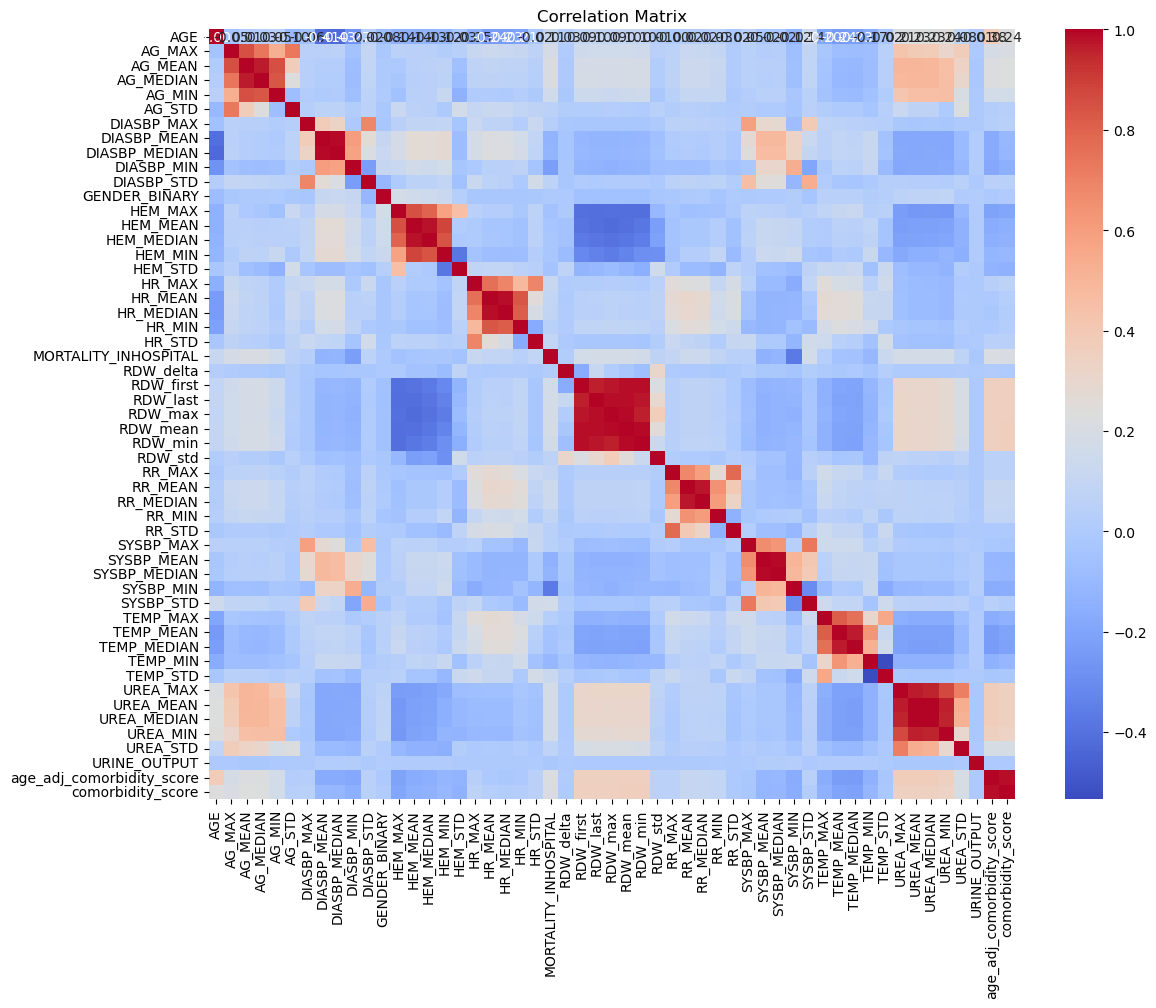

In [33]:
df_corr = final_df_with_rdw.copy()

numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# Exclude columns
id_cols = ['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID', 'HR_COUNT', 'SYSBP_COUNT', 'DIASBP_COUNT', 'TEMP_COUNT', 'AG_COUNT', 'RR_COUNT', 'HEM_COUNT', 'UREA_COUNT', 'RDW_count']
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Sort alphabetically
numeric_cols = sorted(numeric_cols)

df_numeric = df_corr[numeric_cols]
corr_matrix = df_numeric.corr()

# Show correlation of features with target
target_corr = corr_matrix['MORTALITY_INHOSPITAL'].sort_values(ascending=False)
print("Correlation with MORTALITY_INHOSPITAL:\n", target_corr)

# Optional: Visualize correlation matrix
plt.figure(figsize=(13, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [31]:
# Export new feature df as csv
#final_df_with_rdw.to_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine_rdw.csv', index = False)

In [32]:
x = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine_rdw.csv')

x.head(7)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,UREA_COUNT,URINE_OUTPUT,RDW_mean,RDW_min,RDW_max,RDW_std,RDW_first,RDW_last,RDW_count,RDW_delta
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,10.0,380.0,12.925000,12.7,13.1,0.206155,13.1,13.1,4.0,0.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,6.0,8290.0,12.675000,12.5,12.8,0.150000,12.5,12.8,4.0,0.3
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,4.0,4405.0,14.166667,14.0,14.4,0.208167,14.0,14.4,3.0,0.4
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,4.0,3450.0,12.966667,12.6,13.7,0.635085,12.6,13.7,3.0,1.1
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,6.0,2335.0,14.200000,14.1,14.3,0.141421,14.1,14.3,2.0,0.2
5,279,192224,204407,0,81.333333,82.0,7.944681,62.0,96.0,66.0,...,12.0,155.0,18.200000,18.2,18.2,0.000000,18.2,18.2,2.0,0.0
6,281,111199,257572,1,128.075472,122.0,13.051450,111.0,172.0,53.0,...,4.0,1112.0,14.400000,14.1,14.7,0.424264,14.1,14.7,2.0,0.6


#### Hematocrit (HCT)

In [43]:
# ============================================================================
# STEP 1: LOAD ICU STAYS DATA
# ============================================================================
print("Loading ICUSTAYS data...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')

# Convert INTIME to datetime
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Calculate 48h window
icustays['INTIME_48H'] = icustays['INTIME'] + timedelta(hours=48)

print(f"Loaded {len(icustays)} ICU stays")

Loading ICUSTAYS data...
Loaded 61532 ICU stays


In [44]:
# ============================================================================
# STEP 2: LOAD HEMATOCRIT DATA FROM LABEVENTS
# ============================================================================
print("\nLoading LABEVENTS data for Hematocrit...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/LABEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        # Hematocrit Item IDs
        # 51221: Hematocrit (standard hematocrit from complete blood count)
        # 50810: Hematocrit, calculated (from blood gas)
        hematocrit_itemids = [51221, 50810]
        
        hct_chunks = []
        for i, chunk in enumerate(chunk_iterator):
            print(f"Processing LABEVENTS chunk {i+1}...")
            filtered = chunk[chunk['ITEMID'].isin(hematocrit_itemids)]
            if not filtered.empty:
                hct_chunks.append(filtered)
        
        labevents_hct = pd.concat(hct_chunks, ignore_index=True)

print(f"Loaded {len(labevents_hct)} Hematocrit measurements")

# Convert CHARTTIME to datetime
labevents_hct['CHARTTIME'] = pd.to_datetime(labevents_hct['CHARTTIME'])


Loading LABEVENTS data for Hematocrit...
Processing LABEVENTS chunk 1...
Processing LABEVENTS chunk 2...
Processing LABEVENTS chunk 3...
Processing LABEVENTS chunk 4...
Processing LABEVENTS chunk 5...
Processing LABEVENTS chunk 6...
Processing LABEVENTS chunk 7...
Processing LABEVENTS chunk 8...
Processing LABEVENTS chunk 9...
Processing LABEVENTS chunk 10...
Processing LABEVENTS chunk 11...
Processing LABEVENTS chunk 12...
Processing LABEVENTS chunk 13...
Processing LABEVENTS chunk 14...
Processing LABEVENTS chunk 15...
Processing LABEVENTS chunk 16...
Processing LABEVENTS chunk 17...
Processing LABEVENTS chunk 18...
Processing LABEVENTS chunk 19...
Processing LABEVENTS chunk 20...
Processing LABEVENTS chunk 21...
Processing LABEVENTS chunk 22...
Processing LABEVENTS chunk 23...
Processing LABEVENTS chunk 24...
Processing LABEVENTS chunk 25...
Processing LABEVENTS chunk 26...
Processing LABEVENTS chunk 27...
Processing LABEVENTS chunk 28...
Loaded 971479 Hematocrit measurements


In [45]:
# ============================================================================
# STEP 3: MERGE WITH ICU STAYS AND FILTER FOR FIRST 48 HOURS
# ============================================================================
print("\nMerging Hematocrit data with ICU stays...")
hct_icu = labevents_hct.merge(
    icustays[['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'INTIME_48H']], 
    on=['SUBJECT_ID', 'HADM_ID'], 
    how='inner'
)

# Filter for measurements within first 48 hours of ICU admission
hct_icu = hct_icu[
    (hct_icu['CHARTTIME'] >= hct_icu['INTIME']) & 
    (hct_icu['CHARTTIME'] <= hct_icu['INTIME_48H'])
]

print(f"Found {len(hct_icu)} Hematocrit measurements within first 48h of ICU admission")


Merging Hematocrit data with ICU stays...
Found 242718 Hematocrit measurements within first 48h of ICU admission


In [46]:
# ============================================================================
# STEP 4: QUALITY CONTROL - REMOVE OUTLIERS
# ============================================================================
# Normal hematocrit range: approximately 36-50% (men), 34-44% (women)
# Remove obvious outliers (< 10% or > 70%)
print("\nApplying quality control filters...")
before_qc = len(hct_icu)
hct_icu = hct_icu[
    (hct_icu['VALUENUM'].notna()) & 
    (hct_icu['VALUENUM'] >= 0) & 
    (hct_icu['VALUENUM'] <= 75)
]
print(f"Removed {before_qc - len(hct_icu)} outlier measurements")


Applying quality control filters...
Removed 27 outlier measurements


In [58]:
# ============================================================================
# STEP 5: CREATE FEATURES FROM HEMATOCRIT MEASUREMENTS
# ============================================================================
print("\nCreating Hematocrit features...")

# Separate by source
hct_lab = hct_icu[hct_icu['ITEMID'] == 51221].copy()  # Lab hematocrit
hct_calc = hct_icu[hct_icu['ITEMID'] == 50810].copy()  # Calculated from blood gas

# Create aggregated features for lab hematocrit (most commonly used)
hct_features_lab = hct_lab.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'min', 'max', 'std', 'first', 'last', 'count']
}).reset_index()

hct_features_lab.columns = [
    'ICUSTAY_ID', 
    'HCT_mean', 'HCT_min', 'HCT_max', 'HCT_std', 
    'HCT_first', 'HCT_last', 'HCT_count'
]

# Create aggregated features for calculated hematocrit
hct_features_calc = hct_calc.groupby('ICUSTAY_ID').agg({
    'VALUENUM': ['mean', 'min', 'max', 'std', 'first', 'last', 'count']
}).reset_index()

hct_features_calc.columns = [
    'ICUSTAY_ID', 
    'HCT_calc_mean', 'HCT_calc_min', 'HCT_calc_max', 'HCT_calc_std',
    'HCT_calc_first', 'HCT_calc_last', 'HCT_calc_count'
]

# Merge both types
hct_features = hct_features_lab.merge(
    hct_features_calc, 
    on='ICUSTAY_ID', 
    how='outer'
)

# Calculate change features (delta between first and last measurement)
hct_features['HCT_delta'] = hct_features['HCT_last'] - hct_features['HCT_first']
hct_features['HCT_calc_delta'] = hct_features['HCT_calc_last'] - hct_features['HCT_calc_first']

# Create combined features using both sources when available
hct_features['HCT_combined_mean'] = hct_features[['HCT_mean', 'HCT_calc_mean']].mean(axis=1)
hct_features['HCT_combined_min'] = hct_features[['HCT_min', 'HCT_calc_min']].min(axis=1)
hct_features['HCT_combined_max'] = hct_features[['HCT_max', 'HCT_calc_max']].max(axis=1)


Creating Hematocrit features...


In [59]:
hct_features.head(6)

,ICUSTAY_ID,HCT_mean,HCT_min,HCT_max,HCT_std,HCT_first,HCT_last,HCT_count,HCT_calc_mean,HCT_calc_min,HCT_calc_max,HCT_calc_std,HCT_calc_first,HCT_calc_last,HCT_calc_count,HCT_delta,HCT_calc_delta,HCT_combined_mean,HCT_combined_min,HCT_combined_max
0,200001,23.800000,23.6,24.0,0.282843,23.6,24.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,23.800000,23.6,24.0
1,200003,32.333333,30.9,35.0,2.311565,35.0,30.9,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.1,NaN,32.333333,30.9,35.0
2,200006,25.900000,24.8,27.6,1.493318,24.8,25.3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,25.900000,24.8,27.6
3,200007,37.333333,36.5,38.1,0.802081,38.1,36.5,3.0,39.000000,39.0,39.0,NaN,39.0,39.0,1.0,-1.6,0.0,38.166667,36.5,39.0
4,200009,29.366667,26.3,31.2,1.888121,30.3,26.3,9.0,26.285714,21.0,37.0,5.154748,37.0,27.0,7.0,-4.0,-10.0,27.826190,21.0,37.0
5,200010,27.100000,25.9,29.4,1.992486,25.9,29.4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,27.100000,25.9,29.4


In [60]:
hct_features['HCT_mean'].isna().sum()

67

In [61]:
hct_features['HCT_calc_mean'].isna().sum()

43825

In [62]:
hct_features = hct_features[['ICUSTAY_ID', 'HCT_mean', 'HCT_min', 'HCT_max', 'HCT_std', 'HCT_first', 'HCT_last', 'HCT_count']]

In [63]:
hct_features.head(7)

,ICUSTAY_ID,HCT_mean,HCT_min,HCT_max,HCT_std,HCT_first,HCT_last,HCT_count
0,200001,23.800000,23.6,24.0,0.282843,23.6,24.0,2.0
1,200003,32.333333,30.9,35.0,2.311565,35.0,30.9,3.0
2,200006,25.900000,24.8,27.6,1.493318,24.8,25.3,3.0
3,200007,37.333333,36.5,38.1,0.802081,38.1,36.5,3.0
4,200009,29.366667,26.3,31.2,1.888121,30.3,26.3,9.0
5,200010,27.100000,25.9,29.4,1.992486,25.9,29.4,3.0
6,200011,30.800000,30.8,30.8,NaN,30.8,30.8,1.0


In [66]:
features = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine_rdw.csv')

features.head(7)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,UREA_COUNT,URINE_OUTPUT,RDW_mean,RDW_min,RDW_max,RDW_std,RDW_first,RDW_last,RDW_count,RDW_delta
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,10.0,380.0,12.925000,12.7,13.1,0.206155,13.1,13.1,4.0,0.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,6.0,8290.0,12.675000,12.5,12.8,0.150000,12.5,12.8,4.0,0.3
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,4.0,4405.0,14.166667,14.0,14.4,0.208167,14.0,14.4,3.0,0.4
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,4.0,3450.0,12.966667,12.6,13.7,0.635085,12.6,13.7,3.0,1.1
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,6.0,2335.0,14.200000,14.1,14.3,0.141421,14.1,14.3,2.0,0.2
5,279,192224,204407,0,81.333333,82.0,7.944681,62.0,96.0,66.0,...,12.0,155.0,18.200000,18.2,18.2,0.000000,18.2,18.2,2.0,0.0
6,281,111199,257572,1,128.075472,122.0,13.051450,111.0,172.0,53.0,...,4.0,1112.0,14.400000,14.1,14.7,0.424264,14.1,14.7,2.0,0.6


In [67]:
# Merge rdw features to feature df
final_df_with_hct = features.merge(
    hct_features, 
    on='ICUSTAY_ID', 
    how='left'
)

In [68]:
final_df_with_hct.head(4)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,RDW_last,RDW_count,RDW_delta,HCT_mean,HCT_min,HCT_max,HCT_std,HCT_first,HCT_last,HCT_count
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,13.1,4.0,0.0,31.725000,29.3,35.3,2.653771,29.3,30.2,4.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,12.8,4.0,0.3,35.400000,34.6,35.9,0.559762,35.6,34.6,4.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,14.4,3.0,0.4,40.666667,39.0,41.6,1.446836,41.6,39.0,3.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,13.7,3.0,1.1,38.133333,37.7,38.7,0.513160,38.7,38.0,3.0


Correlation with MORTALITY_INHOSPITAL:
 MORTALITY_INHOSPITAL         1.000000
age_adj_comorbidity_score    0.214751
comorbidity_score            0.206490
AG_MEAN                      0.204531
AG_MEDIAN                    0.203589
AG_MAX                       0.180133
RDW_max                      0.177605
UREA_MAX                     0.176772
UREA_MEAN                    0.176580
RDW_last                     0.174563
UREA_MIN                     0.173704
UREA_MEDIAN                  0.173260
RDW_mean                     0.173092
SYSBP_STD                    0.169159
RDW_first                    0.167425
RDW_min                      0.165882
AG_MIN                       0.157463
RR_MEAN                      0.142402
RR_MEDIAN                    0.134513
TEMP_STD                     0.127002
HR_MAX                       0.115573
AGE                          0.114018
RR_MAX                       0.098224
HR_STD                       0.093442
HR_MEAN                      0.091811
RR_MIN    

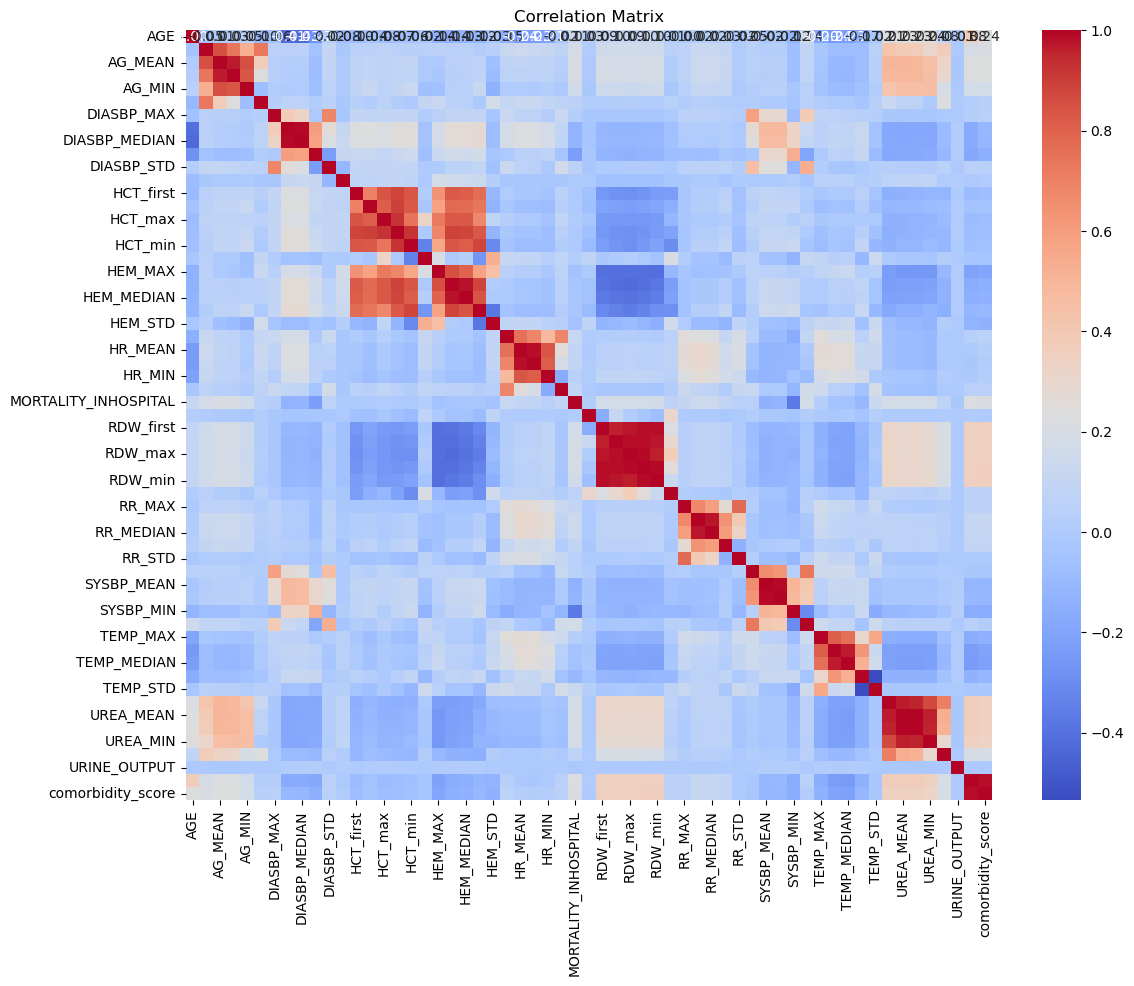

In [70]:
df_corr = final_df_with_hct.copy()

numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# Exclude columns
id_cols = ['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID', 'HR_COUNT', 'SYSBP_COUNT', 'DIASBP_COUNT', 'TEMP_COUNT', 'AG_COUNT', 'RR_COUNT', 'HEM_COUNT', 'UREA_COUNT', 'RDW_count', 'HCT_count']
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Sort alphabetically
numeric_cols = sorted(numeric_cols)

df_numeric = df_corr[numeric_cols]
corr_matrix = df_numeric.corr()

# Show correlation of features with target
target_corr = corr_matrix['MORTALITY_INHOSPITAL'].sort_values(ascending=False)
print("Correlation with MORTALITY_INHOSPITAL:\n", target_corr)

# Optional: Visualize correlation matrix
plt.figure(figsize=(13, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [72]:
# Export new feature df as csv
final_df_with_hct.to_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine_rdw_htc.csv', index = False)

In [73]:
y = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine_rdw_htc.csv')

In [74]:
y.head(9)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,RDW_last,RDW_count,RDW_delta,HCT_mean,HCT_min,HCT_max,HCT_std,HCT_first,HCT_last,HCT_count
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,13.1,4.0,0.0,31.725000,29.3,35.3,2.653771,29.3,30.2,4.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,12.8,4.0,0.3,35.400000,34.6,35.9,0.559762,35.6,34.6,4.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,14.4,3.0,0.4,40.666667,39.0,41.6,1.446836,41.6,39.0,3.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,13.7,3.0,1.1,38.133333,37.7,38.7,0.513160,38.7,38.0,3.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,14.3,2.0,0.2,31.950000,31.8,32.1,0.212132,32.1,31.8,2.0
5,279,192224,204407,0,81.333333,82.0,7.944681,62.0,96.0,66.0,...,18.2,2.0,0.0,29.500000,28.0,30.9,1.140175,29.7,30.9,6.0
6,281,111199,257572,1,128.075472,122.0,13.051450,111.0,172.0,53.0,...,14.7,2.0,0.6,30.000000,28.9,31.1,1.555635,28.9,31.1,2.0
7,283,109185,231490,0,90.611111,94.5,18.039093,66.0,130.0,90.0,...,14.4,3.0,-0.1,25.900000,25.4,26.3,0.458258,26.0,26.3,3.0
8,283,144156,280531,0,97.366667,94.5,10.854924,79.0,116.0,60.0,...,17.4,3.0,-0.1,29.000000,28.9,29.1,0.100000,29.0,29.1,3.0
